<a href="https://colab.research.google.com/github/holms-ur/CellDetection/blob/main/Segmentaci%C3%B3n/Segmentacion_columnas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de segmentación de columnas
Vamos a entrenar nuestro dataset de tablas con distintos modelos utilizando la librería semtorch.
- https://github.com/WaterKnight1998/SemTorch (semtorch)
- https://github.com/WaterKnight1998/Deep-Tumour-Spheroid/tree/develop/notebooks (modelos)

##Librerías

In [1]:
%%capture
!pip install fastai --upgrade

In [2]:
%%capture
!pip install semtorch

In [1]:
%%capture
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

In [2]:
%%capture
%matplotlib inline
import numpy as np

## Dataset


In [3]:
%%capture
!wget https://www.dropbox.com/s/jca752j2mpggbnj/ColumnDataset.zip?dl=1 -O ColumnDataset.zip
!unzip ColumnDataset.zip

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto Path que apunta al directorio que acabamos de crear. 

In [4]:
path=Path('ColumnDataset/')

Como en la práctica anterior, podemos ver el contenido de este directorio usando el comando `ls()`.

In [5]:
path.ls()

(#2) [Path('ColumnDataset/Labels'),Path('ColumnDataset/Images')]

In [6]:
(path/'Images').ls()

(#2) [Path('ColumnDataset/Images/test'),Path('ColumnDataset/Images/train')]

In [7]:
(path/'Images/train').ls()

(#571) [Path('ColumnDataset/Images/train/10.1.1.100.2019_5_1.png'),Path('ColumnDataset/Images/train/10.1.1.160.609_43_0.png'),Path('ColumnDataset/Images/train/10.1.1.178.3004_12_0.png'),Path('ColumnDataset/Images/train/10.1.1.36.8492_1_0.png'),Path('ColumnDataset/Images/train/10.1.1.1.2139_44_0.png'),Path('ColumnDataset/Images/train/10.1.1.180.553_12_0.png'),Path('ColumnDataset/Images/train/10.1.1.170.1004_7_1.png'),Path('ColumnDataset/Images/train/10.1.1.120.1607_4_0.png'),Path('ColumnDataset/Images/train/10.1.1.190.1804_162_0.png'),Path('ColumnDataset/Images/train/10.1.1.8.2124_7_0.png')...]

## Definiciones y funciones previas

El proceso para entrenar nuestro modelo va a ser similar al visto en la práctica 1 para crear un modelo de clasificación. Sin embargo, para cargar nuestro dataset será necesario dar unas definiciones previas. Estas definiciones son necesarias para ajustar la carga del datos a la estructura de nuestro dataset. 

En primer lugar vamos a definir los paths donde se van a encontrar nuestras imágenes y sus etiquetas.

In [8]:
path_images = path/"Images"
path_labels = path/"Labels"

A continuación definimos el nombre que va a tener nuestra carpeta de test. 

In [9]:
test_name = "test"

Seguidamente definimos una función que dado el path de una imagen nos devuelve el path de su anotación.

In [10]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

In [11]:
get_y_fn('/content/ColumnDataset/Images/train/10.1.1.1.2013_63_0.png')

Path('/content/ColumnDataset/Labels/train/10.1.1.1.2013_63_0.png')

Seguidamente cargamos las clases que pueden tener los píxeles de nuestra imágenes y lo almacenamos en una lista `codes`.

In [12]:
codes = array(['Background', 'Column'], dtype='<U10')
codes

array(['Background', 'Column'], dtype='<U10')

In [13]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Column']

{'Background': 0, 'Column': 1}


Podemos ahora ver alguna de las imágenes de nuestro dataset. 

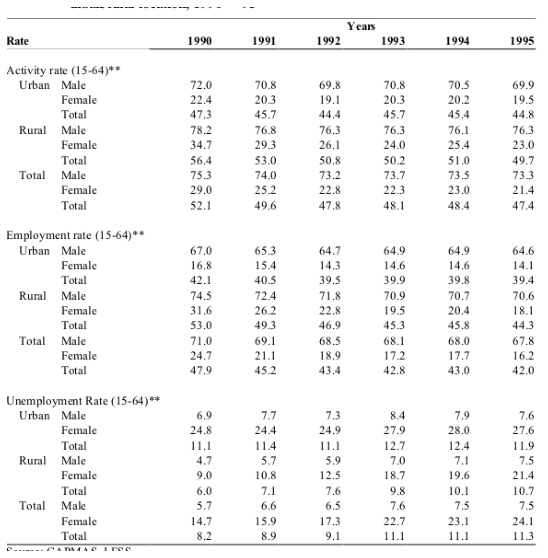

In [14]:
img_f = path_images/'train/10.1.1.1.2013_63_0.png'
img = PILImage.create(img_f)
img.show(figsize=(10, 10))

Y también la anotación asociada.

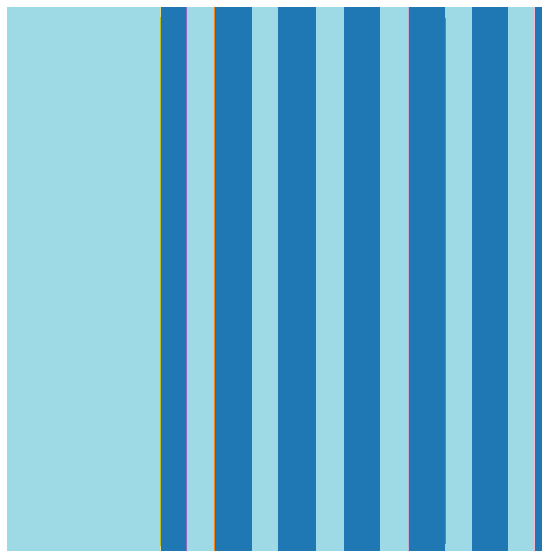

In [15]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(10, 10), alpha=1)

Como podemos ver en la imagen anterior tenemos una máscara donde cada tipo de objeto de nuestra imagen tiene un color distinto. 

In [16]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [17]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [18]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask!=0]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

## Partición del dataset

Como en cualquier problema de machine learning debemos partir nuestro dataset en entrenamiento y test. En nuestro caso los datos ya están separados por lo que vamos a definir una función que nos permite diferenciarlos gracias a la estructura de carpetas que usamos. 

In [19]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

## Creando datablock y dls

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


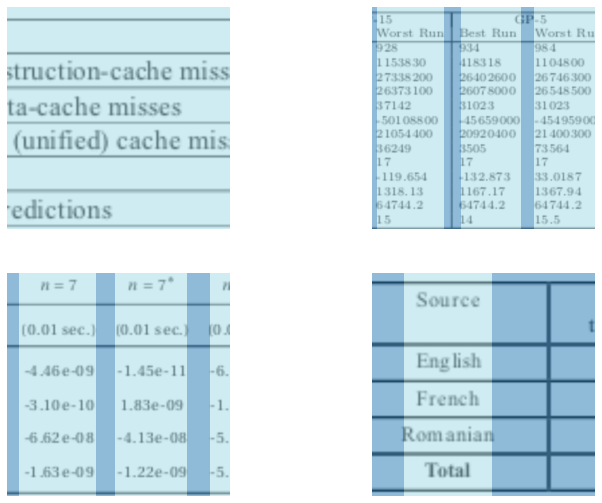

In [20]:
bs = 4
TrainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((600,600)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
trainDLS = TrainDB.dataloaders(path_images,bs=bs)
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((600,600)),TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
testDLS = testDB.dataloaders(path_images,bs=bs)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


## Entrenamiento
Vamos a entrenar los diferentes modelos en igualdad de condiciones para ver cuál es el mejor

### Unet

In [ ]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname='unet')  
]

In [ ]:
learn_unet = get_segmentation_learner(dls=trainDLS, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[Dice,JaccardCoeff]).to_fp16()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.02290867641568184)

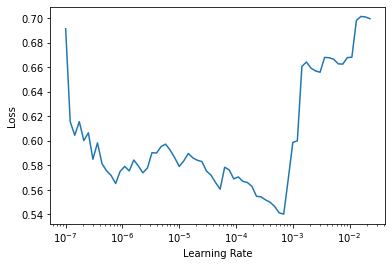

In [ ]:
learn_unet.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.441824,0.463987,0.805738,0.674674,01:27
1,0.424166,0.408449,0.867390,0.765832,01:24
2,0.423743,0.583877,0.847688,0.735641,01:23
3,0.397558,0.380399,0.892048,0.805133,01:23
4,0.362610,0.374593,0.887843,0.798307,01:23
5,0.349052,0.312045,0.903871,0.824602,01:23
6,0.297074,0.315340,0.910689,0.836024,01:23
7,0.284871,0.307564,0.902281,0.821961,01:23
8,0.241756,0.290213,0.913304,0.840440,01:23
9,0.229048,0.279275,0.915877,0.844809,01:23


Better model found at epoch 0 with valid_loss value: 0.46398741006851196.


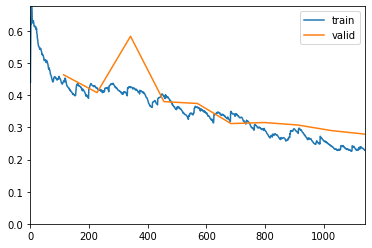

Better model found at epoch 1 with valid_loss value: 0.4084494113922119.
Better model found at epoch 3 with valid_loss value: 0.3803991675376892.
Better model found at epoch 4 with valid_loss value: 0.3745928704738617.
Better model found at epoch 5 with valid_loss value: 0.31204527616500854.
Better model found at epoch 7 with valid_loss value: 0.30756404995918274.
Better model found at epoch 8 with valid_loss value: 0.29021328687667847.
Better model found at epoch 9 with valid_loss value: 0.27927497029304504.


In [ ]:
learn_unet.fit_one_cycle(10, slice(5e-7,5e-4),cbs=callbacks)

### hrnet

In [22]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname='hrnet')  
]

In [23]:
learn_hrnet = get_segmentation_learner(dls=trainDLS, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[Dice,JaccardCoeff]).to_fp16()

147942KB [00:04, 31486.08KB/s]                            


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=7.585775892948732e-05)

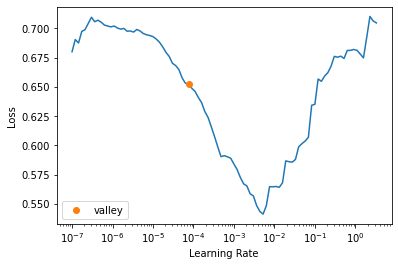

In [24]:
learn_hrnet.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.420917,6.657191,0.692679,0.529846,06:55
1,0.405274,6.981187,0.667295,0.500707,06:51
2,0.381300,7.548471,0.772324,0.629094,06:50


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 6.657190799713135.


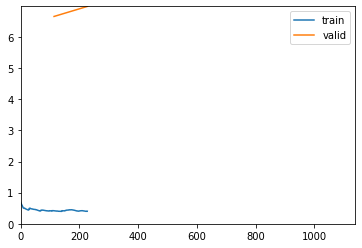

No improvement since epoch 0: early stopping


In [25]:
learn_hrnet.fit_one_cycle(10, slice(1e-4,5e-3),cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=0.00015848931798245758)

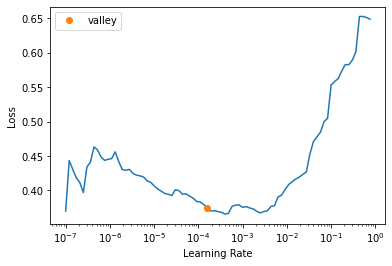

In [26]:
learn_hrnet.unfreeze()
learn_hrnet.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.329139,0.486174,0.836642,0.719161,06:52
1,0.345884,1.281957,0.424768,0.269654,06:52
2,0.328633,0.353797,0.891112,0.803608,06:52
3,0.326813,0.445824,0.846762,0.734247,06:52
4,0.293968,0.341585,0.893625,0.807705,06:51
5,0.287221,0.297858,0.909383,0.833825,06:51
6,0.257455,0.316466,0.911545,0.837467,06:51
7,0.260437,0.281042,0.918200,0.848771,06:52
8,0.229200,0.271742,0.918645,0.849531,06:50
9,0.223158,0.268793,0.919024,0.850181,06:50


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.4861741065979004.


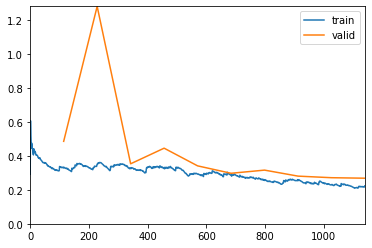

Better model found at epoch 2 with valid_loss value: 0.3537966310977936.
Better model found at epoch 4 with valid_loss value: 0.3415847718715668.
Better model found at epoch 5 with valid_loss value: 0.29785752296447754.
Better model found at epoch 7 with valid_loss value: 0.28104227781295776.
Better model found at epoch 8 with valid_loss value: 0.2717416286468506.
Better model found at epoch 9 with valid_loss value: 0.2687934339046478.


In [27]:
learn_hrnet.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacks)

In [28]:
learn_hrnet.dls = testDLS
learn_hrnet.validate()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.27859237790107727,0.9253109265003314,0.8610033816451721]

### deeplab

In [29]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname='deeplab')  
]

In [ ]:
learn_deeplab = get_segmentation_learner(dls=trainDLS, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[Dice,JaccardCoeff]).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0006918309954926372)

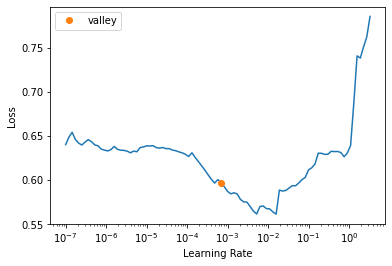

In [31]:
learn_deeplab.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.446908,0.657384,0.769016,0.624716,10:17
1,0.465028,2.610043,0.798808,0.665013,09:59
2,0.414856,0.411170,0.861195,0.756226,09:45
3,0.359451,0.382573,0.878324,0.783047,09:45
4,0.361086,0.357196,0.887022,0.796981,09:46
5,0.352327,0.377114,0.875205,0.778101,09:38
6,0.322856,0.323149,0.900123,0.818384,09:50
7,0.294848,0.304408,0.906829,0.829539,09:45
8,0.289399,0.310645,0.900506,0.819018,09:56
9,0.277620,0.296260,0.909407,0.833865,09:55


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 0.6573839783668518.


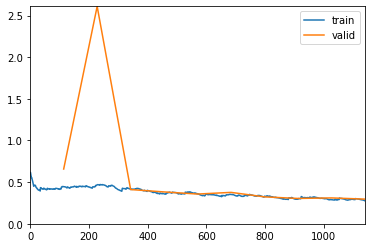

Better model found at epoch 2 with valid_loss value: 0.4111698269844055.
Better model found at epoch 3 with valid_loss value: 0.382572740316391.
Better model found at epoch 4 with valid_loss value: 0.3571959435939789.
Better model found at epoch 6 with valid_loss value: 0.323149174451828.
Better model found at epoch 7 with valid_loss value: 0.30440759658813477.
Better model found at epoch 9 with valid_loss value: 0.29625993967056274.


In [32]:
learn_deeplab.fit_one_cycle(10, slice(7e-4,1e-2),cbs=callbacks)

In [33]:
learn_deeplab.dls = testDLS
learn_deeplab.validate()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.298440545797348,0.9089642941969449,0.8331205746634143]

## Entrenando mejor modelo (Unet)
- Podríamos entrenar el que quisiéramos ya que presentan pocas diferencias. No obstante nos quedamos con Unet

In [ ]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname='unet')  
]

In [ ]:
model = get_segmentation_learner(dls=trainDLS, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[Dice,JaccardCoeff]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.4454397387453355e-05)

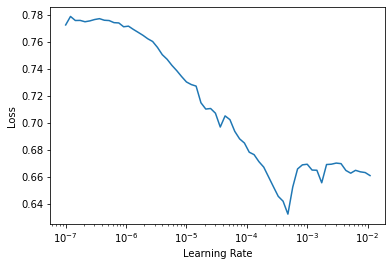

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.462267,0.508916,0.831055,0.710945,01:26
1,0.474198,0.481046,0.813310,0.685360,01:23
2,0.420264,0.402949,0.862888,0.758842,01:22
3,0.410424,0.416648,0.858027,0.751355,01:22
4,0.375131,0.384376,0.884889,0.793543,01:22
5,0.333222,0.347694,0.896002,0.811597,01:22
6,0.306391,0.328599,0.907842,0.831237,01:22
7,0.275735,0.296263,0.911388,0.837202,01:22
8,0.266800,0.283483,0.916524,0.845910,01:22
9,0.251232,0.286154,0.916197,0.845355,01:22


Better model found at epoch 0 with valid_loss value: 0.5089164972305298.


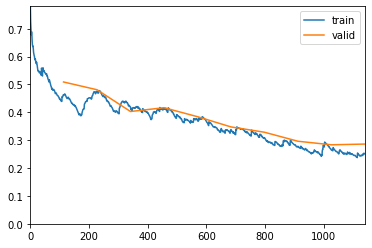

Better model found at epoch 1 with valid_loss value: 0.481046199798584.
Better model found at epoch 2 with valid_loss value: 0.40294912457466125.
Better model found at epoch 4 with valid_loss value: 0.3843756914138794.
Better model found at epoch 5 with valid_loss value: 0.34769406914711.
Better model found at epoch 6 with valid_loss value: 0.3285991847515106.
Better model found at epoch 7 with valid_loss value: 0.29626262187957764.
Better model found at epoch 8 with valid_loss value: 0.28348296880722046.


In [ ]:
model.fit_one_cycle(10, slice(1e-5,1e-3),cbs=callbacks)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

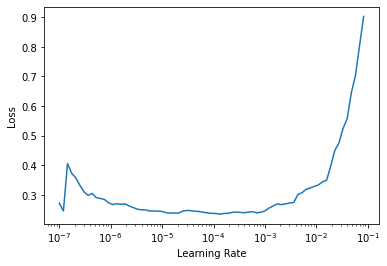

In [ ]:
model.unfreeze()
model.lr_find()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.258960,0.316902,0.914185,0.841934,01:22
1,0.300250,0.337046,0.897649,0.814304,01:22
2,0.329898,0.345435,0.907395,0.830487,01:21


Better model found at epoch 0 with valid_loss value: 0.31690216064453125.


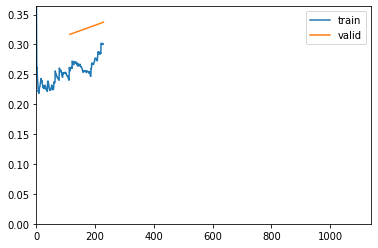

No improvement since epoch 0: early stopping


In [ ]:
model.fit_one_cycle(10, slice(1e-6,7e-4),cbs=callbacks)

In [ ]:
model.dls = testDLS
model.validate()

(#3) [0.30893203616142273,0.9220407783364374,0.8553577536203051]

# Inferencia

In [ ]:
inf_model = get_segmentation_learner(dls=trainDLS, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[Dice,JaccardCoeff]).to_fp16()

In [ ]:
inf_model.load('/content/models/unet')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
inf_model.dls = testDLS
inf_model.validate()

(#3) [0.30893203616142273,0.9220407783364374,0.8553577536203051]

In [ ]:
aux=inf_model.model
aux=aux.cpu()

In [ ]:
import torchvision.transforms as transforms
img = PILImage.create("/content/ColumnDataset/Images/test/10.1.1.1.2006_3_0.png")
transformer=transforms.Compose([transforms.Resize((600,600)),
                                transforms.ToTensor(),
                                Normalize.from_stats(*imagenet_stats)])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))

/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


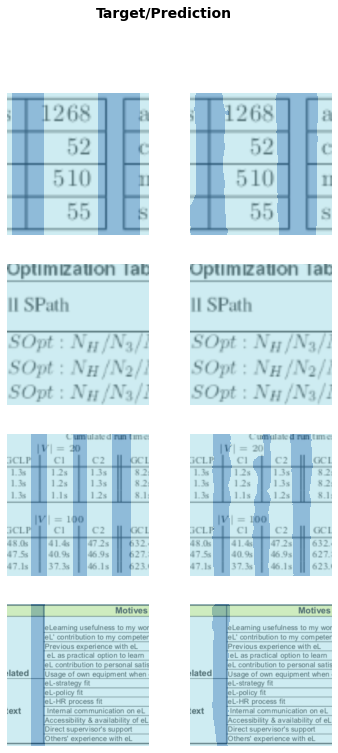

In [ ]:
inf_model.show_results(vmin=0,vmax=1) # show results

In [ ]:
aux=inf_model.model
aux=aux.cpu()

In [ ]:
img = PILImage.create(path_images/'/content/ColumnDataset/Images/train/10.1.1.1.2013_63_0.png')
transformer=transforms.Compose([transforms.Resize((600,600)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("unet.pth")

/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
inf_model = torch.jit.load("unet.pth")
inf_model = inf_model.cpu()
inf_model.eval()

RecursiveScriptModule(
  original_name=DynamicUnet
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu): RecursiveScriptModule(original_name=ReLU)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        )
        (1): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv

In [ ]:
import PIL

In [ ]:
img = PIL.Image.open('/content/ColumnDataset/Images/test/10.1.1.1.2006_3_0.png')

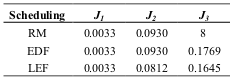

In [ ]:
img

In [ ]:
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [ ]:
image = transforms.Resize((600,600))(img)
tensor = transform_image(image=image)

In [ ]:
inf_model.to(device)
with torch.no_grad():
    outputs = inf_model(tensor)

outputs = torch.argmax(outputs,1)

In [ ]:
mask = np.array(outputs.cpu())
mask[mask==1]=255

In [ ]:
mask=np.reshape(mask,(600,600))

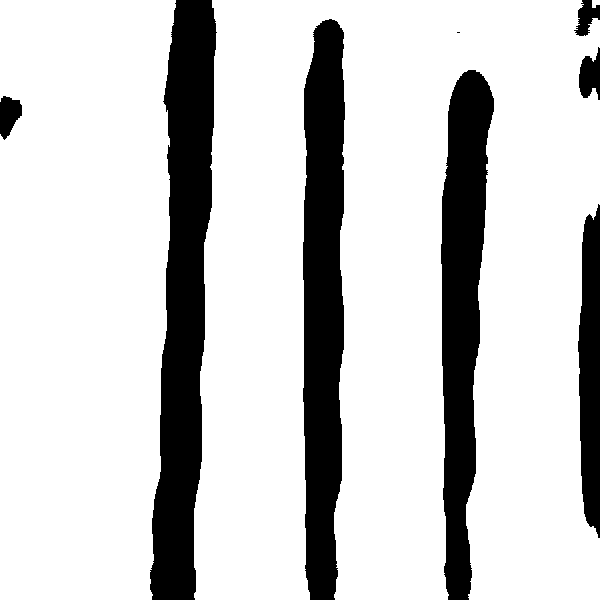

In [ ]:
Image.fromarray(mask.astype('uint8'))